In [1]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline

env: KERAS_BACKEND=tensorflow


In [24]:
import pandas as pd
import numpy as np
import glob
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_error
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler

## Load data

In [5]:
# load all csv files of Insead site. Concatenate them..
data_src = "../data"
data_dst = "../output"
all_files = glob.glob(os.path.join(data_src, "insead", "*.csv"))
df = pd.concat([pd.read_csv(f, low_memory=False) for f in all_files], ignore_index=True)

# minor changes
df = df.rename(columns={"Time Stamp": "timestamp"})
df = df.replace("\\N", np.nan)

# update data types. object is taken as default
dtypes = dict([(col, np.float64) for col in df.columns])
dtypes["timestamp"] = "datetime64[ns]"
df = df.astype(dtypes)

# change the index to timestamp.
df.index = df.timestamp

In [30]:
BATCH_SIZE = 250

## Data sanitizing

In [18]:
# Sample time series. Let's select a period and model for that.. 
ts = df["2017-01-01": "2017-01"]

**TODO:** Split the time series into chunks. Each chunk breaks when the field value is null. Train all the chunks separately.

In [19]:
# Preprocessing: Interpolate null values in the `fields`
# Note: This does not eliminate all null values if their continuous sequence > window size.
fields = ["cwshdr", "loadsys", "drybulb", "rh", "cwrhdr"]
rolling_avg = ts[fields].rolling(10, min_periods=1).mean()

# the time series after some sanitization
ts = ts[fields].fillna(rolling_avg).fillna(method="ffill").dropna()

In [20]:
# Normalize this data..
scaler = MinMaxScaler(feature_range=(0,1))
normalized_ts = scaler.fit_transform(ts)
normalized_ts = pd.DataFrame(normalized_ts, columns=fields, index=ts.index.values)

In [21]:
# split the dataframe for training and validation
# dataframe  := Pandas dataframe
# ratio := Float, training:validation
def train_validation_split(dataframe, ratio):
    size = len(dataframe)
    train_df = dataframe.iloc[0:int(size*ratio)]
    validation_df = dataframe.iloc[int(size*ratio):]
    return train_df, validation_df

train_df, validation_df = train_validation_split(normalized_ts, 0.7)

In [ ]:
# find a length that can be split evenly.. 
l = train_df.shape[0]
l = l - (l % BATCH_SIZE)
train_df[:l]

In [22]:
# prepare feature vectors. the hypothesis is that
# y(t) can be determined using x1(k), x2(k), x3(k).... for all k = {t-1, t-2, t-3, ... t-N}, where 0 <= N <= t-1
def prepare_features(dataframe, target_field, N=1):
    x, y = [], []
    for i in range(len(dataframe)-N-1):
        x.append(dataframe.values[i:i+N])
        y.append(dataframe[target_field].values[i+N])
    x = np.array(x)
    y = np.array(y)
    return x, y

train_x, train_y = prepare_features(train_df, "cwshdr", N=10)
validation_x, validation_y = prepare_features(validation_df, "cwshdr", N=10)

# reshape data. combine all data points corresponding to a y(t)
reshape = lambda a: a.reshape((a.shape[0], a.shape[1] * a.shape[2]))
train_x = reshape(train_x)
validation_x = reshape(validation_x)
train_x.shape, train_y.shape

((31110, 50), (31110,))

## Prepare model

In [28]:
model = Sequential([
    LSTM(15, input_shape=(None, train_x.shape[1]), return_sequences=True),
    LSTM(10, return_sequences=True),
    Dense(1)
])

tb_callback = TensorBoard(
    log_dir=os.path.abspath(data_dst), 
    histogram_freq=0,
    write_graph=True,
    write_images=True
)

model.compile(loss=mean_squared_error, optimizer="adam", metrics=["accuracy"], callbacks=[tb_callback])

## Train model

In [29]:
# This is how keras wants!!
reshape_x = lambda a: a.reshape((a.shape[0], 1, a.shape[1]))
reshape_y = lambda a: a.reshape((a.shape[0], 1, 1))

history = model.fit(
    x=reshape_x(train_x),
    y=reshape_y(train_y),
    validation_data=(reshape_x(validation_x), reshape_y(validation_y)),
    epochs=100)

C:\Anaconda2\envs\py3\lib\site-packages\keras\backend\tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 31110 samples, validate on 13328 samples
Epoch 1/100
31110/31110 [==============================] - 17s - loss: 0.0226 - acc: 4.8216e-04 - val_loss: 2.2242e-04 - val_acc: 0.0000e+00
Epoch 2/100
31110/31110 [==============================] - 15s - loss: 3.8445e-04 - acc: 9.3218e-04 - val_loss: 4.8616e-05 - val_acc: 0.0000e+00
Epoch 3/100
31110/31110 [==============================] - 16s - loss: 2.3129e-04 - acc: 9.6432e-04 - val_loss: 3.0643e-05 - val_acc: 0.0000e+00
Epoch 4/100
31110/31110 [==============================] - 16s - loss: 1.7897e-04 - acc: 9.9646e-04 - val_loss: 2.1383e-05 - val_acc: 0.0000e+00
Epoch 5/100
31110/31110 [==============================] - 15s - loss: 1.5210e-04 - acc: 9.9646e-04 - val_loss: 1.7061e-05 - val_acc: 0.0000e+00
Epoch 6/100
31110/31110 [==============================] - 15s - loss: 1.3922e-04 - acc: 9.9646e-04 - val_loss: 1.4022e-05 - val_acc: 0.0000e+00
Epoch 7/100
31110/31110 [==============================] - 16s - loss: 1.2879e-04 - 

31110/31110 [==============================] - 15s - loss: 8.8102e-05 - acc: 0.0010 - val_loss: 8.6491e-06 - val_acc: 0.0000e+00
Epoch 59/100
31110/31110 [==============================] - 15s - loss: 9.2414e-05 - acc: 0.0010 - val_loss: 1.6131e-05 - val_acc: 0.0000e+00
Epoch 60/100
31110/31110 [==============================] - 15s - loss: 9.3078e-05 - acc: 0.0010 - val_loss: 1.2220e-05 - val_acc: 0.0000e+00
Epoch 61/100
31110/31110 [==============================] - 15s - loss: 9.1495e-05 - acc: 0.0010 - val_loss: 1.0840e-05 - val_acc: 0.0000e+00
Epoch 62/100
31110/31110 [==============================] - 15s - loss: 8.7008e-05 - acc: 0.0010 - val_loss: 1.1495e-05 - val_acc: 0.0000e+00
Epoch 63/100
31110/31110 [==============================] - 16s - loss: 8.8531e-05 - acc: 0.0010 - val_loss: 1.0598e-05 - val_acc: 0.0000e+00
Epoch 64/100
31110/31110 [==============================] - 15s - loss: 8.6607e-05 - acc: 0.0010 - val_loss: 1.1623e-05 - val_acc: 0.0000e+00
Epoch 65/100
31110/

## Metrics

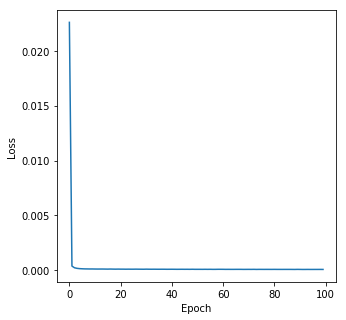

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(history.history["loss"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

In [75]:
predicted_y = model.predict(reshape_x(validation_x))
predicted_y = predicted_y.reshape((predicted_y.shape[0],))

def inv_scaled(y):
    y = y.copy()
    y -= scaler.min_[0]
    y /= scaler.scale_[0]
    return y

from sklearn import metrics
print("MSE: ", metrics.mean_squared_error(inv_scaled(validation_y), inv_scaled(predicted_y)))

MSE:  0.0190696822955


In [42]:
model_file = os.path.join(data_dst, "lstm3.h5")
model.save(model_file)

model_arch_file = os.path.join(data_src, "lstm3.json")
with open(model_arch_file, "wb") as fp:
    fp.write(model.to_json().encode())

## Forecast

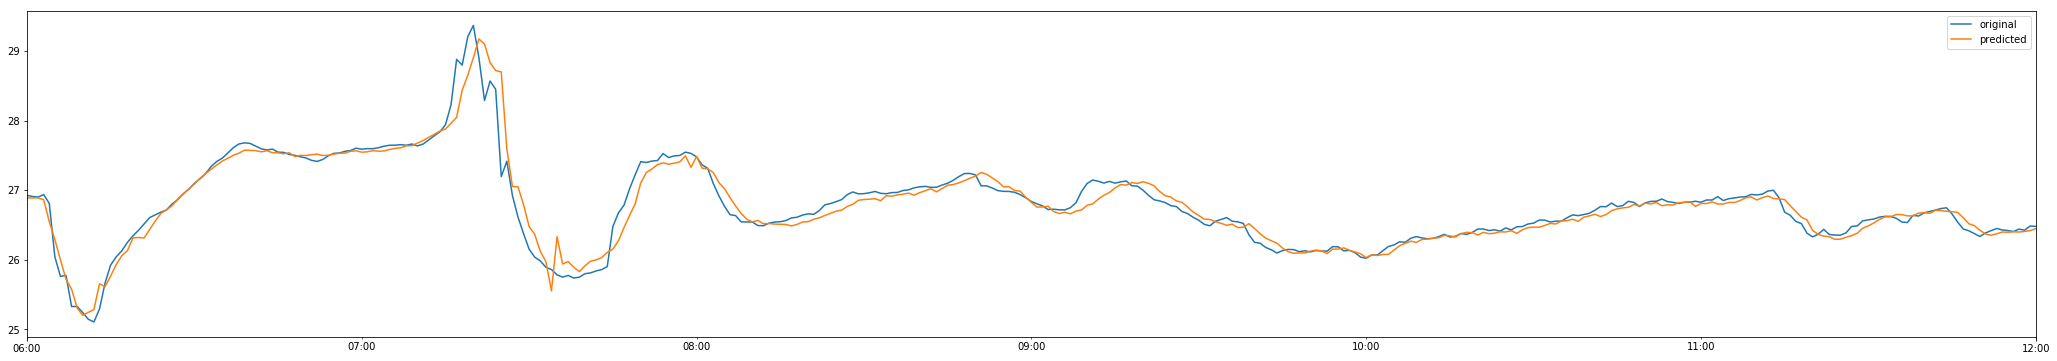

In [79]:
plot_df = pd.DataFrame({
    "original": inv_scaled(validation_y),
    "predicted": inv_scaled(predicted_y)
}, index=validation_df.index.values[11:])  # 11, look back features..

ax = plot_df["2017-01-23 06:00:00":"2017-01-23 12:00:00"].plot(figsize=(36,6))